In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from urllib.parse import urlparse
import re
from urllib.parse import urlparse
import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup

from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/capstone/url/'

In [4]:
ph_df = pd.read_csv(os.path.join(workspace_path, 'mal_domain.csv'), sep=',', header=0, engine='python', encoding='latin1')
norm = pd.read_csv(os.path.join(workspace_path, 'normal_domain.csv'), sep=',', header=0, engine='python', encoding='latin1')
norm1 = pd.read_csv(os.path.join(workspace_path, 'normal1.csv'), sep=',', header=0, engine='python')

In [5]:
# norm1['url'] = 'https://' + norm1['url']
# # ph_df['url'] = 'http://' + ph_df['url']

In [6]:
# ph_df['url'] = 'http://' + ph_df['url']

In [7]:
def remove_http_https(url):
    if url.startswith('https://'):
        return url[len('https://'):]
    elif url.startswith('http://'):
        return url[len('http://'):]
    return url

# 'url' 열에서 접두사를 제거
norm['url'] = norm['url'].apply(remove_http_https)

In [8]:
norm.head()

,url
0,beneaththemassacre.tabsnlyrics.com
1,missionsunknown.com
2,ficcifwi.com
3,theseats.com
4,starbyte.net


In [9]:
norm1.head()

,url
0,google.com
1,youtube.com
2,facebook.com
3,baidu.com
4,wikipedia.org


In [10]:
ph_df.head()

,url
0,0-01x-merchandise.554217.xyz
1,0-02pw.cfd
2,0-0llx.12313123.xyz
3,0-0lx.1231312.xyz
4,0-0lxmarket.5767435.xyz


In [11]:
ph_df.shape

(206042, 1)

In [12]:
print(ph_df.shape)
print(norm.shape)
print(norm1.shape)

(206042, 1)
(150347, 1)
(1000000, 1)


In [13]:
norm_df = pd.concat([norm[:1], norm1[:206000]], ignore_index=True)

ph_df = ph_df.sample(frac=1, random_state=42).reset_index(drop=True)
norm_df = norm_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
norm_df.shape

(206001, 1)

In [15]:
ph_df.shape

(206042, 1)

In [16]:
ph_df.head(20)

,url
0,www.sprawdzoneinfo.pl
1,d2rjyen0wes21v.cloudfront.net
2,uspd.usspaiw.top
3,iarex-news.com
4,liberator1.christianjurek.pl
5,booking.pl-id87142432.xyz
6,mappencil.xyz
7,trueser22.xyz
8,sub416.trdepl.xyz
9,infochat.droptox.xyz


In [17]:
# from urllib.parse import urlparse

# def extract_tld(url):
#     # URL에서 마지막 '.' 이후의 부분을 TLD로 추출
#     tld = url.split('.')[-1] if '.' in url else ''
#     return tld

# def extract_tlds(df):
#     tlds = set()
#     for url in df['url']:
#         if pd.notna(url) and isinstance(url, str):
#             tld = extract_tld(url)
#             tlds.add(tld)
#     return tlds

# # 정상 URL 데이터프레임의 TLD 추출
# norm_tlds = extract_tlds(norm_df)
# print("정상 URL TLD:")
# print(norm_tlds)

# # 피싱 URL 데이터프레임의 TLD 추출
# ph_tlds = extract_tlds(ph_df)
# print("피싱 URL TLD:")
# print(ph_tlds)

In [18]:
import re
import string
from urllib.parse import urlparse
import pandas as pd

# IP 주소 여부를 확인하는 함수
def is_ip_address(hostname):
    # IP 주소 형식을 확인하는 정규 표현식
    ip_pattern = re.compile("^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$")
    return bool(ip_pattern.match(hostname))

# 자음 확인을 위한 함수
def is_consonant(char):
    return char.isalpha() and char.lower() not in ['a', 'e', 'i', 'o', 'u']

# 특수 문자 개수 계산 함수
def count_special_chars(url):
    special_chars = set(string.punctuation)
    return sum(char in special_chars for char in url)

# URL 길이 계산 함수
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

# URL에서 피처 추출 함수
def extract_features(url):
    url = url.replace('www.', '')

    if ':' in url:
        url = url.split(':')[0]

    # IP 주소 사용 여부 피처 추가
    having_ip_address = 1 if is_ip_address(url) else 0
    abnormal_url = 0 if url == "" else 1

    # 도메인에서 숫자의 비율 계산
    digit_count = sum(c.isdigit() for c in url)
    digit_ratio = digit_count / len(url) if len(url) > 0 else 0

    # 연속된 숫자의 최대 개수 찾기
    max_consecutive_digits = 0
    current_sequence_digits = 0

    for c in url:
        if c.isdigit():
            current_sequence_digits += 1
            max_consecutive_digits = max(max_consecutive_digits, current_sequence_digits)
        else:
            current_sequence_digits = 0

    # 도메인에서 자음의 비율 계산
    consonant_count = sum(is_consonant(c) for c in url)
    consonant_ratio = consonant_count / len(url) if len(url) > 0 else 0

    # 연속된 자음의 최대 개수 찾기
    max_consecutive_consonants = 0
    current_sequence_consonants = 0

    for c in url:
        if is_consonant(c):
            current_sequence_consonants += 1
            max_consecutive_consonants = max(max_consecutive_consonants, current_sequence_consonants)
        else:
            current_sequence_consonants = 0

    # 특수 문자 개수 계산
    special_chars_count = count_special_chars(url)

    # TLD 추출
    tld = url.split('.')[-1] if '.' in url else ''

    # TLD에서 자음의 비율 계산
    tld_consonant_count = sum(is_consonant(c) for c in tld)
    tld_consonant_ratio = tld_consonant_count / len(tld) if len(tld) > 0 else 0

    features = {
        'contains_dash': int('-' in url), # '-' 문자 사용 여부
        'url_length': get_url_length(url),  # 전체 URL 길이
        'digit_ratio': digit_ratio,  # 도메인에서 숫자의 비율
        'max_consecutive_digits': max_consecutive_digits,  # 연속된 숫자의 최대 개수
        'subdomain_count': url.count('.') - (1 if url.startswith('www.') else 0), # 서브 도메인 개수
        'consonant_ratio': consonant_ratio,  # 도메인 내의 자음 비율
        'special_chars_count': special_chars_count, # 특수 문자 개수
        'tld_consonant_ratio': tld_consonant_ratio,  # TLD 내의 자음 비율
        'max_consecutive_consonants': max_consecutive_consonants,  # 연속된 자음의 최대 개수
    }
    return features

# 데이터프레임에 피처 추출 적용 함수
def extract_features_from_dataframe(df):
    features_list = []
    for url in df['url']:
        if pd.notna(url) and isinstance(url, str):
            features = extract_features(url)
            features_list.append(features)
        else:
            continue

    features_df = pd.DataFrame(features_list)
    return features_df


In [19]:
# 피처 추출
ph_features_df = extract_features_from_dataframe(ph_df)
norm_features_df = extract_features_from_dataframe(norm_df)

In [20]:
# 피싱 및 정상 데이터셋에 레이블 추가
ph_features_df['label'] = 1  # 피싱 URL
norm_features_df['label'] = 0  # 정상 URL

In [21]:
# 데이터셋 병합
ph_val = ph_features_df.sample(n=20000, random_state=42)
ph_train = ph_features_df.drop(ph_val.index)

norm_val = norm_features_df.sample(n=20000, random_state=42)
norm_train = norm_features_df.drop(norm_val.index)

valset = pd.concat([ph_val, norm_val])
df = pd.concat([ph_train, norm_train], ignore_index=True)

In [22]:
df.head()

,contains_dash,url_length,digit_ratio,max_consecutive_digits,subdomain_count,consonant_ratio,special_chars_count,tld_consonant_ratio,max_consecutive_consonants,label
0,0,17,0.000000,0,1,0.647059,1,1.000000,3,1
1,0,29,0.137931,2,2,0.586207,2,0.666667,3,1
2,0,16,0.000000,0,2,0.562500,2,0.666667,3,1
3,1,14,0.000000,0,1,0.500000,2,0.666667,2,1
4,1,25,0.320000,8,2,0.400000,3,1.000000,3,1


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372043 entries, 0 to 372042
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   contains_dash               372043 non-null  int64  
 1   url_length                  372043 non-null  int64  
 2   digit_ratio                 372043 non-null  float64
 3   max_consecutive_digits      372043 non-null  int64  
 4   subdomain_count             372043 non-null  int64  
 5   consonant_ratio             372043 non-null  float64
 6   special_chars_count         372043 non-null  int64  
 7   tld_consonant_ratio         372043 non-null  float64
 8   max_consecutive_consonants  372043 non-null  int64  
 9   label                       372043 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 28.4 MB


In [24]:
df_corr = df.corr(method='pearson')
df_corr

,contains_dash,url_length,digit_ratio,max_consecutive_digits,subdomain_count,consonant_ratio,special_chars_count,tld_consonant_ratio,max_consecutive_consonants,label
contains_dash,1.000000,0.372927,0.166741,0.285131,0.257757,-0.209850,0.732424,0.066235,0.013563,0.301021
url_length,0.372927,1.000000,0.399534,0.496342,0.616531,-0.222730,0.655969,0.145800,0.297694,0.459760
digit_ratio,0.166741,0.399534,1.000000,0.897713,0.398187,-0.606595,0.356199,0.234396,0.009324,0.280056
max_consecutive_digits,0.285131,0.496342,0.897713,1.000000,0.458688,-0.560034,0.482085,0.233022,0.051998,0.325939
subdomain_count,0.257757,0.616531,0.398187,0.458688,1.000000,-0.275012,0.784530,0.212784,0.146837,0.361145
consonant_ratio,-0.209850,-0.222730,-0.606595,-0.560034,-0.275012,1.000000,-0.299791,0.144642,0.465163,-0.100497
special_chars_count,0.732424,0.655969,0.356199,0.482085,0.784530,-0.299791,1.000000,0.166679,0.107977,0.402212
tld_consonant_ratio,0.066235,0.145800,0.234396,0.233022,0.212784,0.144642,0.166679,1.000000,0.091184,0.156438
max_consecutive_consonants,0.013563,0.297694,0.009324,0.051998,0.146837,0.465163,0.107977,0.091184,1.000000,0.217330
label,0.301021,0.459760,0.280056,0.325939,0.361145,-0.100497,0.402212,0.156438,0.217330,1.000000


In [25]:
# df.url_length.value_counts()

In [26]:
df.label.value_counts()

label
1    186042
0    186001
Name: count, dtype: int64

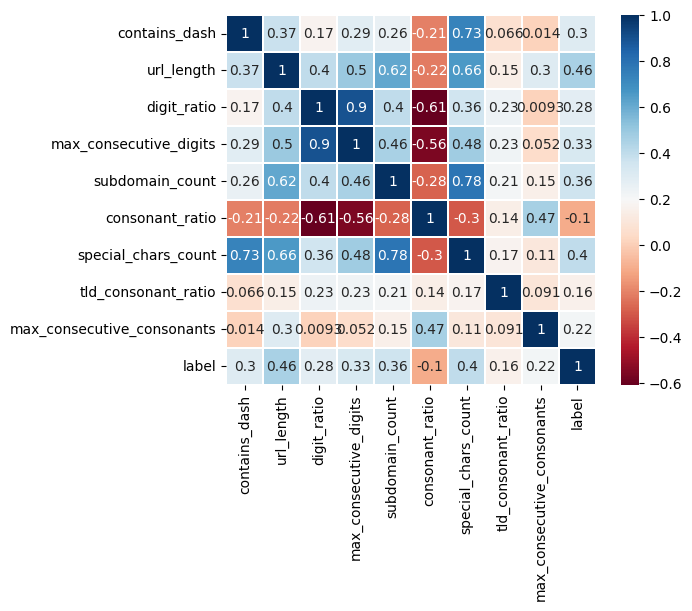

In [27]:
heatmap_data = df.select_dtypes(include=[np.number])
colormap = plt.cm.RdBu
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True,
            annot_kws={'size': 10})
plt.show()

In [28]:
# 데이터 준비 (독립 변수와 종속 변수 분리)
X = df.drop(columns=['label'])
y = df['label']
val_input = valset.drop(columns=['label'])
val_target = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input.columns = val_input.columns.str.replace('[^a-zA-Z0-9]', '_')
X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LGBM 모델

In [29]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM 모델 설정 (나머지 코드는 이전과 동일)
params = {
    'objective': 'binary',  # 이진 분류 설정
    'metric': 'binary_error',  # 이진 분류 정확도 측정
    'boosting_type': 'rf',  # Gradient Boosting Decision Tree
    'num_leaves': 63,  # 과적합 방지를 위해 트리의 최대 잎 노드 수 줄임
    'learning_rate': 0.01,  # 과적합 방지를 위해 낮은 학습률 설정
    'feature_fraction': 0.9,  # 트리마다 무작위로 선택되는 피처 비율 줄임
    'bagging_fraction': 0.9,  # 각 반복마다 무작위로 선택되는 데이터 비율 줄임
    'bagging_freq': 5,  # 5번의 반복마다 배깅 수행
    'lambda_l1': 0.1,  # L1 정규화 적용
    'lambda_l2': 0.1,  # L2 정규화 적용
    'max_depth': 15  # 과적합 방지를 위해 트리의 최대 깊이 제한
}

In [30]:
# LightGBM 모델 학습
num_round = 20  # 트리 수 (조정 가능)
lgb_model = lgb.train(params, train_data, num_round)

[LightGBM] [Info] Number of positive: 148891, number of negative: 148743
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 588
[LightGBM] [Info] Number of data points in the train set: 297634, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500249 -> initscore=0.000995
[LightGBM] [Info] Start training from score 0.000995


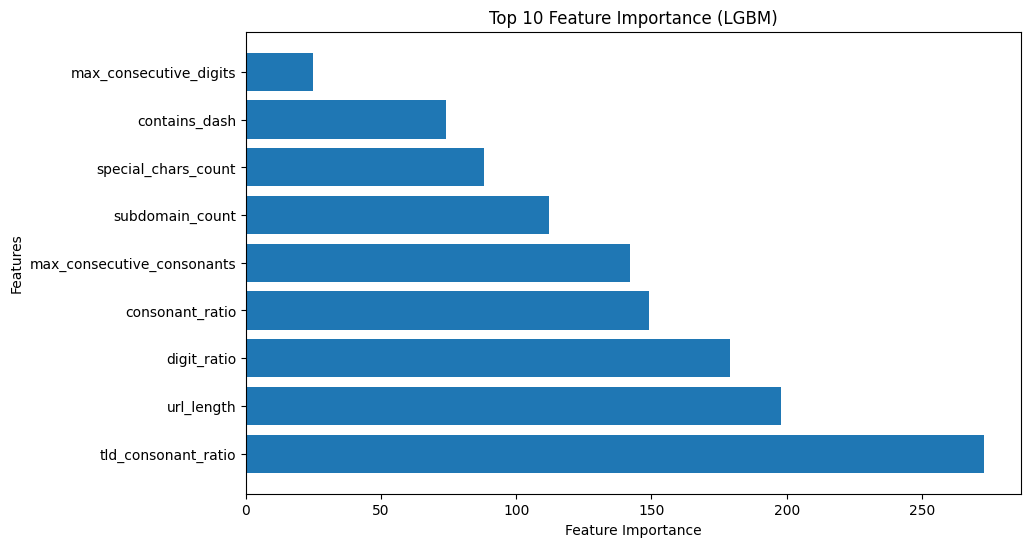

In [31]:
import matplotlib.pyplot as plt

# LightGBM 모델에서 피쳐 중요도 가져오기
feature_importance = lgb_model.feature_importance()
feature_names = X_train.columns

# 중요도를 피쳐 이름과 연결
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피쳐만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (LGBM)'.format(top_n))
plt.show()


In [32]:
# 모델 예측
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_binary_lgb = [1 if pred > 0.5 else 0 for pred in y_pred_lgb]  # 이진 예측

In [33]:
# 정확도 출력
accuracy_lgb = accuracy_score(y_test, y_pred_binary_lgb)
print("Accuracy:", accuracy_lgb)

# 분류 보고서 출력
classification_rep_lgb = classification_report(y_test, y_pred_binary_lgb)
print("Classification Report:\n", classification_rep_lgb)

# 혼동 행렬 출력
conf_matrix_lgb = confusion_matrix(y_test, y_pred_binary_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)

Accuracy: 0.792793882460455
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81     37258
           1       0.86      0.70      0.77     37151

    accuracy                           0.79     74409
   macro avg       0.80      0.79      0.79     74409
weighted avg       0.80      0.79      0.79     74409

Confusion Matrix:
 [[32848  4410]
 [11008 26143]]


In [34]:
# 검증 데이터 예측
val_pred_lgb = lgb_model.predict(val_input, num_iteration=lgb_model.best_iteration)
val_pred_binary_lgb = [1 if pred > 0.5 else 0 for pred in val_pred_lgb]  # 이진 예측

In [35]:
# 정확도 출력
accuracy_val_lgb = accuracy_score(val_target, val_pred_binary_lgb)
print("Accuracy:", accuracy_val_lgb)

# 분류 보고서 출력
classification_val_lgb = classification_report(val_target, val_pred_binary_lgb)
print("Classification Report:\n", classification_val_lgb)

Accuracy: 0.78975
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81     20000
           1       0.85      0.70      0.77     20000

    accuracy                           0.79     40000
   macro avg       0.80      0.79      0.79     40000
weighted avg       0.80      0.79      0.79     40000



# RandomForest

In [36]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # 랜덤 포레스트 모델 생성 및 학습
# rf_model = RandomForestClassifier(random_state=42,
#                                    n_estimators=150,
#                                    criterion='log_loss',
#                                    n_jobs=2,

#                                    )
# rf_model.fit(X_train, y_train)

In [37]:
# import matplotlib.pyplot as plt

# # 학습된 Random Forest 모델에서 피처 중요도 가져오기
# feature_importance = rf_model.feature_importances_

# # 각 피처와 그 중요도를 연결
# feature_names = X_train.columns
# feature_importance_dict = dict(zip(feature_names, feature_importance))

# # 중요도를 기준으로 내림차순 정렬
# sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# # 상위 N개의 피처만 선택 (예: 상위 10개)
# top_n = 10
# top_features = dict(sorted_feature_importance[:top_n])

# # 그래프로 시각화
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(top_features)), top_features.values(), align='center')
# plt.yticks(range(len(top_features)), top_features.keys())
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Top {} Feature Importance (Random Forest)'.format(top_n))
# plt.show()


In [38]:
# # 모델 예측
# y_pred_rf = rf_model.predict(X_test)

In [39]:
# # 정확도 출력
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# print("Accuracy:", accuracy_rf)

# # 분류 보고서 출력
# classification_rep_rf = classification_report(y_test, y_pred_rf)
# print("Classification Report:\n", classification_rep_rf)

# # 혼동 행렬 출력
# conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
# print("Confusion Matrix:\n", conf_matrix_rf)

In [40]:
# # 모델 예측
# val_pred_rf = rf_model.predict(val_input)

In [41]:
# # 정확도 출력
# accuracy_val_rf = accuracy_score(val_target, val_pred_rf)
# print("Accuracy:", accuracy_val_rf)

# # 분류 보고서 출력
# classification_val_rf = classification_report(val_target, val_pred_rf)
# print("Classification Report:\n", classification_val_rf)

# # 혼동 행렬 출력
# conf_matrix_val_rf = confusion_matrix(y_test, y_pred_rf)
# print("Confusion Matrix:\n", conf_matrix_val_rf)

# XGBOOST

In [64]:
# 데이터 준비 (독립 변수와 종속 변수 분리)
X = df.drop(columns=['label'])
y = df['label']
val_input = valset.drop(columns=['label'])
val_target = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input.columns = val_input.columns.str.replace('[^a-zA-Z0-9]', '_')
X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# XGBoost 데이터셋 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 모델 설정
params = {
    'objective': 'binary:logistic',  # 이진 분류 설정
    'eval_metric': 'error',  # 이진 분류 오류율
    'booster': 'dart',  # 트리 기반 모델
    'max_depth': 30,  # 트리의 최대 깊이
    'eta': 0.0005,  # 학습률
    'subsample': 0.9,  # 훈련 데이터의 하위 샘플 비율
    'lambda': 1
}

In [65]:
# XGBoost 모델 학습
num_round = 50  # 부스팅 라운드 수 (조정 가능)
bst = xgb.train(params, dtrain, num_round)

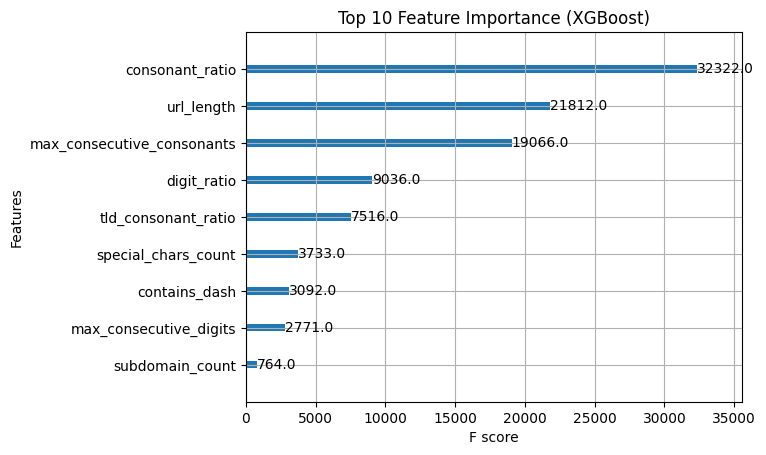

In [66]:
# 피쳐 중요도 가져오기 및 시각화
xgb.plot_importance(bst, max_num_features=10)
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()


In [67]:
# 모델 예측
y_pred_xgb = bst.predict(dtest)
y_pred_binary_xgb = [1 if pred > 0.5 else 0 for pred in y_pred_xgb]  # 이진 예측


In [68]:
# 정확도 출력
accuracy_xgb = accuracy_score(y_test, y_pred_binary_xgb)
print("Accuracy:", accuracy_xgb)


Accuracy: 0.7986937064064831


In [69]:
# 분류 보고서 출력
classification_rep_xgb = classification_report(y_test, y_pred_binary_xgb)
print("Classification Report:\n", classification_rep_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81     37258
           1       0.86      0.72      0.78     37151

    accuracy                           0.80     74409
   macro avg       0.81      0.80      0.80     74409
weighted avg       0.81      0.80      0.80     74409



In [70]:
# 혼동 행렬 출력
conf_matrix_xgb = confusion_matrix(y_test, y_pred_binary_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

Confusion Matrix:
 [[32858  4400]
 [10579 26572]]


In [71]:
# 검증 데이터셋에 대한 예측
dval = xgb.DMatrix(val_input)
val_pred_xgb = bst.predict(dval)
val_pred_binary_xgb = [1 if pred > 0.5 else 0 for pred in val_pred_xgb]  # 이진 예측

# 정확도 출력
accuracy_val_xgb = accuracy_score(val_target, val_pred_binary_xgb)
print("Validation Accuracy:", accuracy_val_xgb)

# 분류 보고서 출력
classification_val_xgb = classification_report(val_target, val_pred_binary_xgb)  # val_pred6 대신 val_pred_binary 사용
print("Classification Report:\n", classification_val_xgb)

# 혼동 행렬 출력
conf_matrix_val_xgb = confusion_matrix(val_target, val_pred_binary_xgb)  # val_pred6 대신 val_pred_binary 사용
print("Confusion Matrix:\n", conf_matrix_val_xgb)

Validation Accuracy: 0.79645
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81     20000
           1       0.86      0.71      0.78     20000

    accuracy                           0.80     40000
   macro avg       0.81      0.80      0.79     40000
weighted avg       0.81      0.80      0.79     40000

Confusion Matrix:
 [[17613  2387]
 [ 5755 14245]]


# 모델 비교평가

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = y_test
y_pred_lgbm = y_pred_binary_lgb
# y_pred_rf = y_pred_?rf
y_pred_xgb = y_pred_binary_xgb

# 각 모델의 성능 지표 계산
# models = ['LightGBM', 'Random Forest', 'XGB']
# y_preds = [y_pred_lgbm,  y_pred_rf,  y_pred_xgb]

models = ['LightGBM', 'XGB']
y_preds = [y_pred_lgbm,  y_pred_xgb]


# models = ['LightGBM', 'Random Forest', 'XGB']
# y_preds = [y_pred_lgbm,  y_pred_rf,  y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


LightGBM - Accuracy: 0.79, Precision: 0.86, Recall: 0.70, F1 Score: 0.77
XGB - Accuracy: 0.80, Precision: 0.86, Recall: 0.72, F1 Score: 0.78


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = val_target
y_pred_lgbm = val_pred_binary_lgb
# y_pred_rf = val_pred_rf
y_pred_xgb = val_pred_binary_xgb

# 각 모델의 성능 지표 계산
models = ['LightGBM', 'XGB']
y_preds = [y_pred_lgbm, y_pred_xgb]

# models = ['LightGBM', 'XGB']
# y_preds = [y_pred_lgbm,  y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

LightGBM - Accuracy: 0.79, Precision: 0.85, Recall: 0.70, F1 Score: 0.77
XGB - Accuracy: 0.80, Precision: 0.86, Recall: 0.71, F1 Score: 0.78


In [74]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # 예측 결과와 실제 레이블
# # 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
# y_test = val_target
# y_pred_lgbm = val_pred_binary_lgb
# y_pred_rf = val_pred_rf
# y_pred_xgb = val_pred_binary_xgb

# # 각 모델의 성능 지표 계산
# models = ['LightGBM',  'Random Forest', 'XGB']
# y_preds = [y_pred_lgbm, y_pred_rf, y_pred_xgb]

# # models = ['LightGBM', 'XGB']
# # y_preds = [y_pred_lgbm,  y_pred_xgb]

# for model, y_pred in zip(models, y_preds):
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")